In [1]:
using DrWatson
quickactivate(@__DIR__)

import Baysor as B
import BaysorAnalysis as BA
import Colors
import MultivariateStats
import Plots
import Clustering
import ColorSchemes
import CSV
import CairoMakie as MK
import JSON
import Images
import PyPlot as Plt
import Seaborn as Sns
import HypothesisTests

using DataFrames
using DataFramesMeta
using NearestNeighbors
using LinearAlgebra
using ProgressMeter
using OrderedCollections
using SparseArrays
using Statistics
using StatsBase
using StatsPlots
using VegaLite

ProgressMeter.ijulia_behavior(:clear);
MK.activate!(type = "png");
BA.set_pyplot_defaults!()

cplotsdir(args...) = plotsdir("benchmarking/merfish_membrane", args...);

## Load data

In [2]:
df_spatial, gene_names = B.load_df(datadir("exp_pro/merfish_membrane/baysor_selected_3d/segmentation.csv"));
seg_df = B.load_df(datadir("exp_pro/merfish_membrane/baysor_selected_dapi_3d_prior/segmentation.csv"))[1]
df_pciseq = DataFrame!(CSV.File((datadir("exp_pro/merfish_membrane/pciseq/spots.csv"))));

df_spatial[!,:cell_dp] = seg_df.cell;
df_spatial[!,:cell_mp] = B.load_df(datadir("exp_pro/merfish_membrane/baysor_selected_membrane_3d_prior/segmentation.csv"))[1].cell;
df_spatial[!,:cell_pciseq] = df_pciseq[.!startswith.(df_pciseq.Gene, "Blank"),:].neighbour;
df_spatial[!,:cell_dapi] = seg_df.dapi_prior_3d;
df_spatial[!,:cell_membrane] = seg_df.membrane_prior_3d;

size(df_spatial)

(819665, 25)

In [3]:
aliases = OrderedDict([
#     :cell => "Baysor", :cell_dp => "Baysor, DAPI prior", :cell_mp => "Baysor, IF prior", 
    :cell => "Baysor", :cell_dp => "Baysor+DAPI", :cell_mp => "Baysor+IF", 
    :cell_dapi => "DAPI", :cell_membrane => "IF", :cell_pciseq => "pciSeq"
]);
cell_cols = collect(keys(aliases));

color_per_label = BA.method_palette();
for (k1, k2) in [("DAPI", "Watershed"), ("Baysor+IF", "Baysor, IF prior"), ("Baysor+DAPI", "Baysor, DAPI prior")]
    color_per_label[k1] = color_per_label[k2];
    delete!(color_per_label, k2);
end

In [4]:
# c_data = Dict(:df => deepcopy(df_spatial), :min_area => 1.0, :min_mols_per_cell => 30, :name => "MERFISH");
c_data = Dict(:df => deepcopy(@where(df_spatial, :z_raw .> 4.1, :z_raw .< 12.9)), :min_area => 1.0, :min_mols_per_cell => 10, :name => "MERFISH");
# c_data = Dict(:df => deepcopy(@where(df_spatial, :z_raw .≈ 8.5)), :min_area => 1.0, :min_mols_per_cell => 10, :name => "MERFISH");
@time BA.append_matching_statistics!(c_data, cell_cols; target_cell_col_names=[:cell_membrane]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


 28.690626 seconds (32.74 M allocations: 5.903 GiB, 4.36% gc time, 54.04% compilation time)


In [5]:
name_map = [:cell_dapi => :match_res_dapi_membrane, :cell_mp => :match_res_mp_membrane, :cell_dp => :match_res_dp_membrane, 
    :cell => :match_res_cell_membrane, :cell_pciseq => :match_res_pciseq_membrane]
pr_dfs = Dict(aliases[c] => BA.precision_recall_df(c_data[f].contingency) for (c,f) in name_map);

In [6]:
assign_stat_df = DataFrame(Dict(
    :Type => aliases[k], :NCells => length(unique(v)) - 1, :NoiseFrac => round(mean(v .== 0), digits=3), :MedMols => median(B.count_array(v, drop_zero=true)
)) for (k,v) in c_data[:assignment_filt])
assign_stat_df = @orderby(assign_stat_df, :Type);

In [7]:
z_vals = sort(unique(c_data[:df].z_raw));
comp_cols = [:cell, :cell_dp, :cell_mp, :cell_pciseq, :cell_dapi];

## Example

In [8]:
@time membrane = Images.load(datadir("exp_raw/merfish_membrane/membrane_selected.tif"));
@time dapi = Images.load(datadir("exp_raw/merfish_membrane/dapi_selected.tif"));

 15.735121 seconds (2.30 M allocations: 1.481 GiB, 3.19% gc time, 10.34% compilation time)


### Intracellular structure

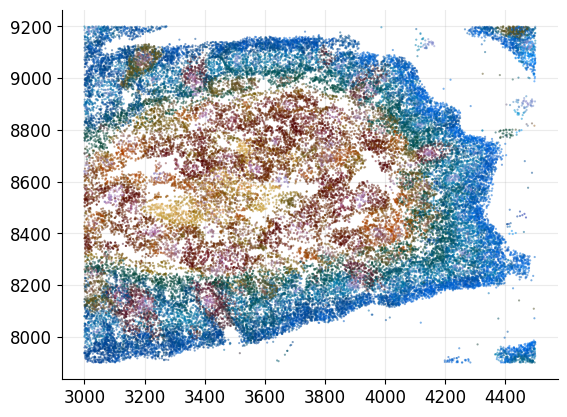

PyObject <matplotlib.collections.PathCollection object at 0x7f90534ac160>

In [248]:
(xs, xe), (ys, ye) = (3000, 4500), (7900, 9200)
p_df = deepcopy(@where(df_spatial, :x .>= xs, :x .<= xe, :y .>= ys, :y .<= ye))
Plt.scatter(p_df.x, p_df.y, s=0.3, color=p_df.ncv_color, alpha=0.5)
# Plt.imshow(Int.(Float16.(membrane[ys:ye, xs:xe, 5]) .* 255), cmap="twilight")
# Plt.scatter(p_df.x .- xs, p_df.y .- ys, s=0.3, color=p_df.ncv_color, alpha=0.5)

In [10]:
neighb_cm = B.neighborhood_count_matrix(p_df, 20);
@time transformation = B.gene_composition_transformation(neighb_cm, p_df.confidence, spread=2.0, min_dist=1.0, sample_size=20000);
@time gene_colors = B.gene_composition_colors(neighb_cm, transformation, lrange=(10, 90));
p_df[!,:ncv_color] = "#" .* hex.(gene_colors);

 84.223389 seconds (6.65 M allocations: 1.443 GiB, 0.34% gc time, 5.47% compilation time)
  8.839551 seconds (14.11 M allocations: 924.586 MiB, 1.12% gc time)


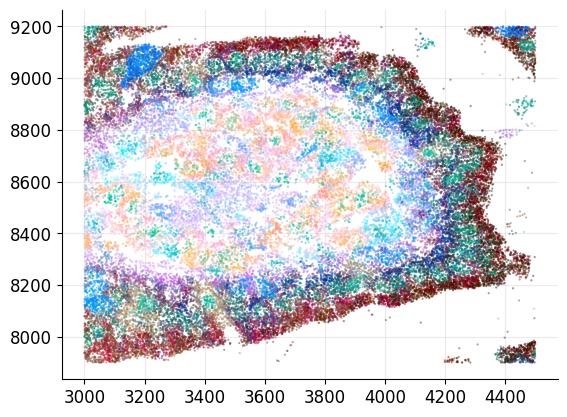

PyObject <matplotlib.collections.PathCollection object at 0x7f90ab1d42e0>

In [11]:
Plt.scatter(p_df.x, p_df.y, s=0.3, color=p_df.ncv_color, alpha=0.5)

In [203]:
CSV.write(datadir("exp_pro/merfish_membrane/subs_ncv_updated.csv"), p_df);

In [182]:
# polygons = B.boundary_polygons(p_df2, p_df2.cell; grid_step=3., bandwidth=10.);
# for p in polygons
#     Plt.fill(p[:,1] .- xs, p[:,2] .- ys, facecolor="none", edgecolor="black")
# end

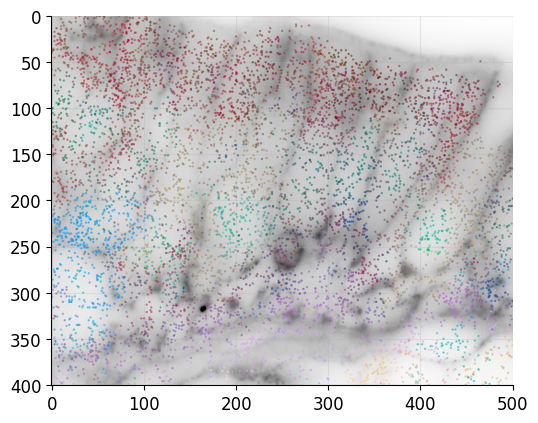

PyObject <matplotlib.collections.PathCollection object at 0x7fbcd9bbcca0>

In [200]:
(xs, xe), (ys, ye) = (3000, 3500), (7900, 8300)
p_df2 = @where(p_df, :x .>= xs, :x .<= xe, :y .>= ys, :y .<= ye)

Plt.imshow(Int.(Float16.(membrane[ys:ye, xs:xe, 5]) .* 255), cmap="Greys")
# Plt.scatter(p_df2.x, p_df2.y, s=0.5, color=p_df2.ncv_color, alpha=0.5)
Plt.scatter(p_df2.x .- xs, p_df2.y .- ys, s=0.5, color=p_df2.ncv_color, alpha=0.5)

### 3D structure

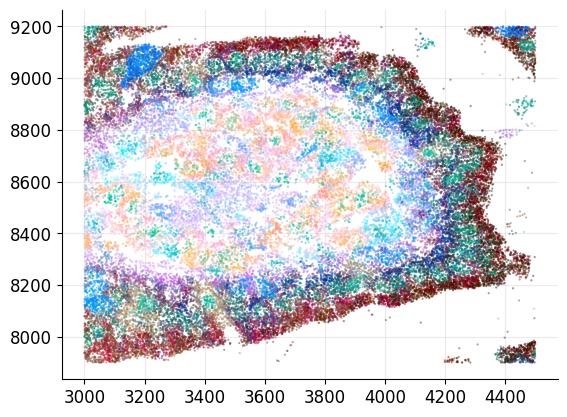

PyObject <matplotlib.collections.PathCollection object at 0x7f90ab1d42e0>

In [11]:
Plt.scatter(p_df.x, p_df.y, s=0.3, color=p_df.ncv_color, alpha=0.5)

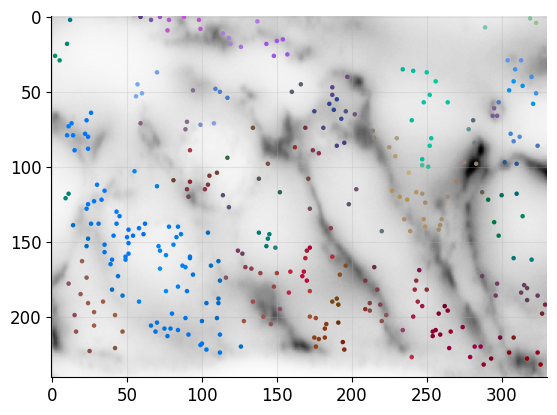

PyObject <matplotlib.collections.PathCollection object at 0x7f904bb6e880>

In [436]:
# # (xs, xe), (ys, ye) = (4000, 4400), (8600, 8800) # 3
# (xs, xe), (ys, ye) = (3400, 3700), (8100, 8300) # 1
# (xs, xe), (ys, ye) = (3300, 3800), (8000, 8400) # 1
# (xs, xe), (ys, ye) = (3000, 3700), (8900, 9200) # 0
(xs, xe), (ys, ye) = (3120, 3450), (8900, 9140)
z_id = 7
p_df2 = @where(p_df, :x .>= xs, :x .<= xe, :y .>= ys, :y .<= ye, :z_raw .≈ sort(unique(p_df.z_raw))[z_id])

Plt.imshow(Int.(Float16.(membrane[ys:ye, xs:xe, z_id]) .* 255), cmap="Greys")
Plt.scatter(p_df2.x .- xs, p_df2.y .- ys, s=5, color=p_df2.ncv_color, alpha=1)

## Main figure

In [8]:
# pr_main_methods = ("Baysor, DAPI prior", "pciSeq", "DAPI");
pr_main_methods = ("Baysor+DAPI", "pciSeq", "DAPI");

In [9]:
cm_membrane = B.convert_segmentation_to_counts(c_data[:df].gene, c_data[:assignment_filt][:cell_membrane]);
overlap_ids = filter.(x -> x != 0, B.split(c_data[:assignment_filt][:cell_membrane], c_data[:assignment_filt][:cell] .+ 1)[2:end]);
overlap_ids = filter(x -> length(x) > 1, [findall(B.count_array(v) .> 5) for v in overlap_ids if length(v) > 0]);

cell_centers = copy(vcat([mean(Matrix(c_data[:df][ids,[:x,:y,:z]]), dims=1) for ids in B.split_ids(c_data[:assignment_filt][:cell_membrane] .+ 1)[2:end]]...)');

all_cors = vcat([BA.vec_triu(cor(cm_membrane[:, ids])) for ids in knn(KDTree(cell_centers), cell_centers, 5)[1]]...);
overlap_cors = vcat([BA.vec_triu(cor(cm_membrane[:, ids])) for ids in overlap_ids]...);

In [28]:
mask = (c_data[:assignment_filt][:cell_membrane] .!= 0)
as_filt = c_data[:assignment_filt]
mut_info_df = vcat([DataFrame(
    :mi => [Clustering.mutualinfo(as_filt[:cell_membrane][mask .& (c_data[:df].z_raw .≈ z)], as_filt[c][mask .& (c_data[:df].z_raw .≈ z)]) for z in z_vals],
    :method => aliases[c]
) for c in comp_cols]...);

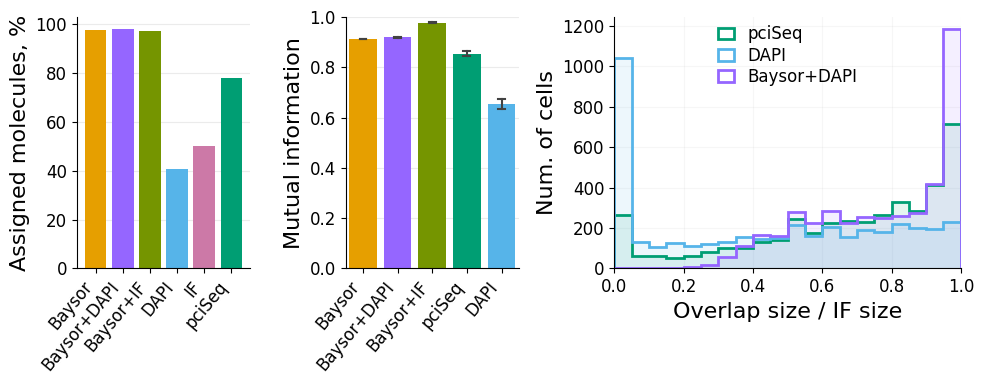

In [29]:
fig, axes = Plt.subplots(1, 3, figsize=(10, 4), gridspec_kw=Dict("width_ratios" => [1, 1, 2]))

axes[1].bar(1:size(assign_stat_df, 1), (1 .- assign_stat_df.NoiseFrac) .* 100, color=[color_per_label[k] for k in assign_stat_df.Type]);
axes[1].set_xticks(1:size(assign_stat_df, 1));
axes[1].set_xticklabels(assign_stat_df.Type, rotation=50, ha="right");
axes[1].set_ylabel("Assigned molecules, %");
axes[1].grid(axis="x");

Sns.barplot(x=mut_info_df.method, y=mut_info_df.mi, capsize=0.2, ax=axes[2], palette=color_per_label, saturation=1, errwidth=1.5, ci=99)
# axes[2].bar(1:length(comp_cols), mut_infos, color=[color_per_label[aliases[k]] for k in comp_cols]);
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=50, ha="right");
axes[2].set_ylabel("Mutual information");
axes[2].set_ylim(0, 1);

BA.plot_precision_recall(Dict(k => pr_dfs[k] for k in pr_main_methods); col=:recall, ax=axes[3],
    color_per_label=color_per_label, xlabel="Overlap size / IF size", legend_title="");

Plt.tight_layout()
Plt.savefig(cplotsdir("main.pdf"))

## Supplements

In [15]:
as_filt = c_data[:assignment_filt]
mask = any(hcat([(as_filt[c] .!= 0) for c in vcat(comp_cols, :cell_membrane)]...), dims=2)[:];
# mut_infos = [Clustering.mutualinfo(c_data[:assignment_filt][:cell_membrane][mask], c_data[:assignment_filt][c][mask]) for c in comp_cols];
mut_info_df = vcat([DataFrame(
    :mi => [Clustering.mutualinfo(as_filt[:cell_membrane][mask .& (c_data[:df].z_raw .≈ z)], as_filt[c][mask .& (c_data[:df].z_raw .≈ z)]) for z in z_vals],
    :method => aliases[c]
) for c in comp_cols]...);

In [16]:
n_mol_df = vcat([DataFrame(Dict(:n => B.count_array(c_data[:assignment_filt][k], drop_zero=true), :t => aliases[k])) for k in cell_cols]...);

pos_data = B.position_data(c_data[:df]);
area_df = vcat([DataFrame(:n => [B.area(B.convex_hull(pos_data[1:2,ids])) for ids in B.split_ids(c_data[:assignment_filt][k] .+ 1)[2:end]], :t => aliases[k]) 
        for k in cell_cols]...);

In [17]:
n_overlaps_df = vcat([DataFrame(
    :n_cells => B.count_array(df.n_overlaps .+ 1), 
    :n_overlaps => minimum(df.n_overlaps):maximum(df.n_overlaps), 
    :method => k
) for (k, df) in pr_dfs]...);

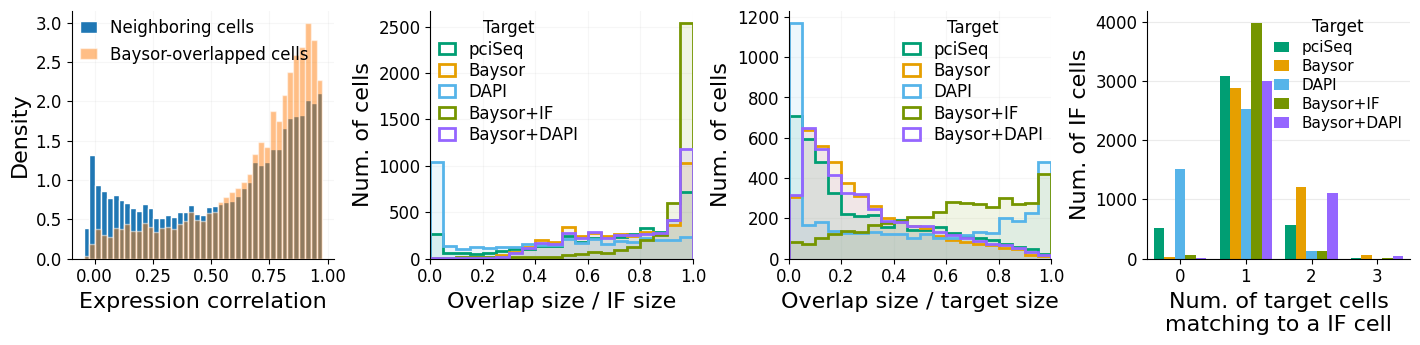

In [21]:
fig, (ax_bright, ax_recall, ax_prec, ax_n_over) = Plt.subplots(1, 4, figsize=(14, 3.25))

bins = min(0, minimum(all_cors)):0.025:1.0
ax_bright.hist(all_cors, bins=bins, edgecolor="white", density=true, label="Neighboring cells");
ax_bright.hist(overlap_cors, bins=bins, edgecolor="white", density=true, alpha=0.5, label="Baysor-overlapped cells");
ax_bright.set_xlabel("Expression correlation"); ax_bright.set_ylabel("Density");
ax_bright.grid(true, alpha=0.1);
ax_bright.legend(handlelength=1.0);

BA.plot_precision_recall(pr_dfs; col=:recall, ax=ax_recall, color_per_label=color_per_label, xlabel="Overlap size / IF size");
BA.plot_precision_recall(pr_dfs; col=:precision, ax=ax_prec, color_per_label=color_per_label, xlabel="Overlap size / target size");

Sns.barplot(x=n_overlaps_df.n_overlaps, y=n_overlaps_df.n_cells, hue=n_overlaps_df.method, palette=color_per_label,
    saturation=1, ax=ax_n_over)
ax_n_over.set_xlabel("Num. of target cells\nmatching to a IF cell"); ax_n_over.set_ylabel("Num. of IF cells")
ax_n_over.legend(handlelength=1, labelspacing=0.25, fontsize=11, title="Target");

Plt.tight_layout(pad=0)
Plt.savefig(cplotsdir("supp_part1.pdf"))

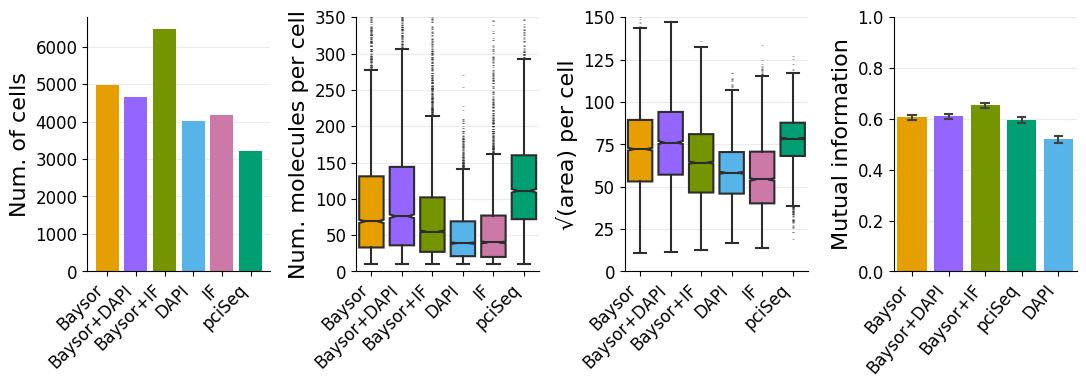

In [26]:
fig, (ax_ncells, ax_n_mols, ax_area, ax_mi) = Plt.subplots(1, 4, figsize=(11, 4), gridspec_kw=Dict("width_ratios" => [1, 1, 1, 1]))

ax_ncells.bar(1:size(assign_stat_df, 1), assign_stat_df.NCells, color=[color_per_label[k] for k in assign_stat_df.Type]);
ax_ncells.set_xticks(1:size(assign_stat_df, 1))
ax_ncells.set_xticklabels(assign_stat_df.Type, rotation=45, ha="right");
ax_ncells.set_ylabel("Num. of cells");
ax_ncells.grid(axis="x");

Sns.boxplot(x=n_mol_df.t, y=n_mol_df.n, palette=color_per_label, notch=true, fliersize=0.1, saturation=1, ax=ax_n_mols)
ax_n_mols.set_xticklabels(ax_n_mols.get_xticklabels(), rotation=45, ha="right");
ax_n_mols.grid(false, axis="x")
ax_n_mols.set_ylim(0, 350)
ax_n_mols.set_ylabel("Num. molecules per cell");

Sns.boxplot(x=area_df.t, y=sqrt.(area_df.n), palette=color_per_label, notch=true, fliersize=0.1, saturation=1, ax=ax_area)
ax_area.set_xticklabels(ax_area.get_xticklabels(), rotation=45, ha="right");
ax_area.grid(false, axis="x")
ax_area.set_ylim(0, 150)
ax_area.set_ylabel("√(area) per cell")

Sns.barplot(x=mut_info_df.method, y=mut_info_df.mi, capsize=0.2, ax=ax_mi, palette=color_per_label, saturation=1, errwidth=1.5, ci=99)
ax_mi.set_xticklabels(ax_mi.get_xticklabels(), rotation=50, ha="right");
ax_mi.set_ylabel("Mutual information");
ax_mi.set_ylim(0, 1);

Plt.tight_layout(pad=1)
Plt.savefig(cplotsdir("supp_part2.pdf"))